### LSTM Multivariate for time series forecasting on the Air Pollution dataset
From: Vicente Guerrero

https://viclule.github.io/

Date: 14.03.2019


Based on the article from Jason Brownlee.
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

##### Air Pollution dataset
This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

    No: row number
    year: year of data in this row
    month: month of data in this row
    day: day of data in this row
    hour: hour of data in this row
    pm2.5: PM2.5 concentration
    DEWP: Dew Point
    TEMP: Temperature
    PRES: Pressure
    cbwd: Combined wind direction
    Iws: Cumulated wind speed
    Is: Cumulated hours of snow
    Ir: Cumulated hours of rain

#### 1. Basic Data Preparation

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from datetime import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
df = pd.read_csv('pollution.csv', parse_dates = [['year', 'month', 'day', 'hour']],
                      index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)
# manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)
# drop the first 24 hours that contain NaN values
df = df[24:]
# save to file
df.to_csv('pollution_processed.csv')
df.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


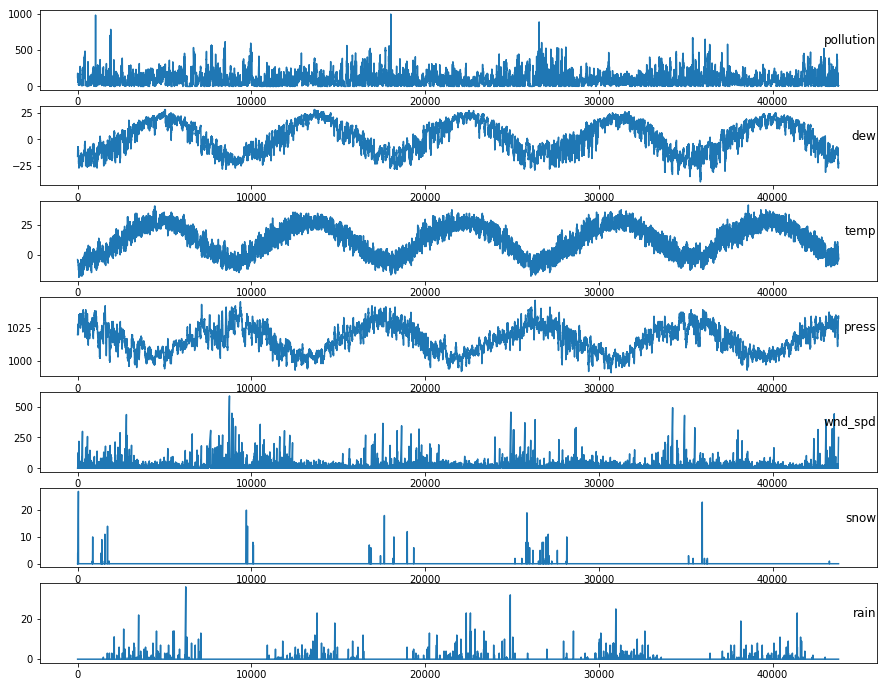

In [3]:
# plots each series as a separate subplot, except wnd_dir, which is categorical.
values = df.values
# specify columns to plot
groups = list(range(values.shape[1]))
groups.remove(4)
i = 1
# plot each column
plt.figure(figsize=(15,12))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

#### 2. Baseline model
The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

In [4]:
# create a lagged
df = pd.read_csv('pollution_processed.csv', header=0, usecols=[1])
df = pd.concat([df.shift(1), df], axis=1)
df.columns = ['t-1', 't+1']
print(df.head(3))

     t-1    t+1
0    NaN  129.0
1  129.0  148.0
2  148.0  159.0


In [5]:
# split into train and test sets
values = df.values
n_train_hours = 365 * 24
train = values[1:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:,0], train[:,1]   # the t- features, the first t feature 
test_X, test_y = test[:,0], test[:,1]
print(train_X.shape, len(train_X), test_X.shape)

(8759,) 8759 (35040,)


In [6]:
# persistence model
def model_persistence(x):
    return x

In [7]:
from sklearn.metrics import mean_squared_error

# walk-forward validation
predictions = []
for x, y in zip(test_X, test_y):
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = math.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)

Test RMSE: 26.559


#### 3. Multivariate LSTM Forecast Model

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# load dataset
df = pd.read_csv('pollution_processed.csv', header=0, index_col=0)
values = df.values

# one-hot encoding wnd_dir
label_encoder = LabelEncoder()
values[:,4] = label_encoder.fit_transform(values[:,4])
one_hot_encoder = OneHotEncoder(sparse=False)
wnd_dir_one_hot = one_hot_encoder.fit_transform(values[:,4].reshape(-1, 1))

In [7]:
# drop the original column
print('before one-hot:', values.shape)
idxs = list(range(values.shape[1]))
idxs.remove(4)
values = values[:, idxs]
# insert wnd_dir one-hot encoded
values = np.insert(values, [4], values=wnd_dir_one_hot, axis=1)
print('after one-hot:', values.shape)

before one-hot: (43800, 8)
after one-hot: (43800, 11)


In [8]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 11  # features is now 11, after one-hot
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 44)


In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
# X are the features from t-3, t-2 and t-1, Y is var1 t
train_X, train_y = train[:, :n_obs], train[:, -n_features]   # the t- features, the first t feature 
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 33) 8760 (8760,)


In [10]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 11) (8760,) (35037, 3, 11) (35037,)


In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/30
 - 5s - loss: 0.0489 - val_loss: 0.0572
Epoch 2/30
 - 3s - loss: 0.0259 - val_loss: 0.0400
Epoch 3/30
 - 3s - loss: 0.0216 - val_loss: 0.0302
Epoch 4/30
 - 3s - loss: 0.0206 - val_loss: 0.0258
Epoch 5/30
 - 3s - loss: 0.0201 - val_loss: 0.0235
Epoch 6/30
 - 3s - loss: 0.0198 - val_loss: 0.0209
Epoch 7/30
 - 3s - loss: 0.0196 - val_loss: 0.0199
Epoch 8/30
 - 3s - loss: 0.0190 - val_loss: 0.0189
Epoch 9/30
 - 3s - loss: 0.0187 - val_loss: 0.0184
Epoch 10/30
 - 3s - loss: 0.0182 - val_loss: 0.0182
Epoch 11/30
 - 3s - loss: 0.0180 - val_loss: 0.0176
Epoch 12/30
 - 3s - loss: 0.0174 - val_loss: 0.0176
Epoch 13/30
 - 3s - loss: 0.0175 - val_loss: 0.0168
Epoch 14/30
 - 3s - loss: 0.0170 - val_loss: 0.0184
Epoch 15/30
 - 3s - loss: 0.0166 - val_loss: 0.0159
Epoch 16/30
 - 3s - loss: 0.0162 - val_loss: 0.0162
Epoch 17/30
 - 3s - loss: 0.0160 - val_loss: 0.0158
Epoch 18/30
 - 3s - loss: 0.0158 - val_loss: 0.0159
Epoch 19/30
 - 3s - loss

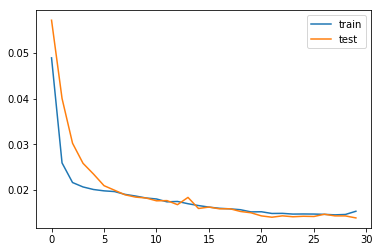

In [12]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss')
plt.legend()
plt.show()

In [13]:
test_X.shape

(35037, 3, 11)

In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -10:]), axis=1)  # -10 -> number of features minus 1
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -10:]), axis=1)  # -10 -> number of features minus 1
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.412


There is no improvement in comparison to the base model (RMSE: 26.559).